<a href="https://colab.research.google.com/github/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import json
import os
import random

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

git_folder = "/content/Detection-of-Sensitive-Data-Exposure-in-Images"
if os.path.exists(git_folder) == False:
  !git clone https://github.com/DhilipSanjay/Detection-of-Sensitive-Data-Exposure-in-Images.git

dataset_folder = git_folder + "/text_dataset/"
sensitive_datafile = "SensitiveDataset.json"
nonsensitive_datafile = "NonSensitiveDataset.json"

In [3]:
vocab_size = 2000
embedding_dim = 16
max_length = 60
truncation_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [7]:
dataList = []
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

def loadDataset(filename):
  with open(dataset_folder + filename, 'r') as f:
      datastore = json.load(f)
  for item in datastore:
    sentence = item['data']
    label = item['is_sensitive']
    # for word in stopwords: #Remove stop words in sentence
    #   token = " " + word + " "
    #   sentence = sentence.replace(token, " ")
    dataList.append([sentence, label])

loadDataset(sensitive_datafile)
loadDataset(nonsensitive_datafile)

random.shuffle(dataList)
print("Dataset Size: ", len(dataList))

for item in dataList:
  sentences.append(item[0])
  labels.append(item[1])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

print("Training Dataset Size: ", len(training_sentences))
print("Sample Training Data:", training_sentences[-100:])
print("Testing Dataset Size: ", len(testing_sentences))
print("Sample Training Data:", testing_sentences[-100:])

Dataset Size:  31576
Training Dataset Size:  20000
Sample Training Data: ['username:almeria, password:101010, email:almeria@free.fr, phone no:4586157751', "Charlotte Dreyfus, a wealthy cosmetic tycoon, and her 12-year-old daughter Nicole, who's dying from leukemia, strike up a sentimental friendship with a California politician, Patrick Dalton. Nicole has decided to abandon all further treatments for the disease because of the treatments' side effects.\nSince the girl has only six weeks or less to live, the trio fly to New York City, where the daughter skates the ice rink at Rockefeller Center, assumes the lead role of Marie in The Nutcracker with the New York City Ballet at Lincoln Center, and sightsees most of the city. During her subway ride returning from her triumphant performance in the Tchaikovsky ballet, she suddenly collapses and dies in her mother's arms, having achieved her lifelong dream.\nCharlotte gets on a plane to Paris alone. Patrick writes to her, imploring her to kee

In [10]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

with open("word_index.json", "w") as outfile:  
    json.dump(word_index, outfile)
    print("Saving the word index as JSON")

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)

Saving the word index as JSON


In [11]:
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 16)            32000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 32,433
Trainable params: 32,433
Non-trainable params: 0
_________________________________________________________________


In [13]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.1633 - accuracy: 0.9840 - val_loss: 0.0239 - val_accuracy: 0.9920
Epoch 2/30
625/625 - 1s - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.0078 - val_accuracy: 0.9976
Epoch 3/30
625/625 - 1s - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0036 - val_accuracy: 0.9988
Epoch 4/30
625/625 - 1s - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.0020 - val_accuracy: 0.9997
Epoch 5/30
625/625 - 1s - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.0013 - val_accuracy: 0.9998
Epoch 6/30
625/625 - 1s - loss: 8.9637e-04 - accuracy: 0.9998 - val_loss: 0.0010 - val_accuracy: 0.9998
Epoch 7/30
625/625 - 1s - loss: 6.3416e-04 - accuracy: 0.9998 - val_loss: 8.0137e-04 - val_accuracy: 0.9998
Epoch 8/30
625/625 - 1s - loss: 4.7659e-04 - accuracy: 0.9999 - val_loss: 6.4586e-04 - val_accuracy: 0.9998
Epoch 9/30
625/625 - 1s - loss: 3.7009e-04 - accuracy: 0.9999 - val_loss: 4.6929e-04 - val_accuracy: 0.9998
Epoch 10/30
625/625 - 1s - loss: 2.8790e-04 - accuracy: 0.9999 - val_los

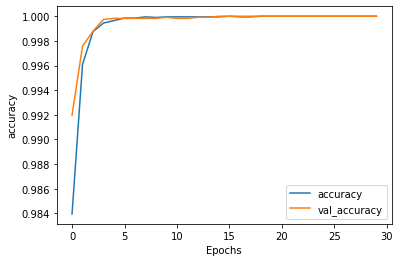

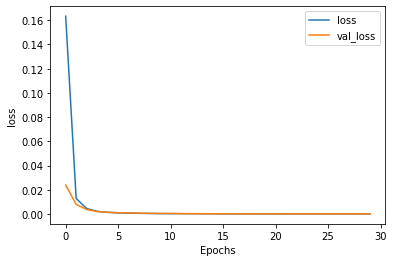

In [14]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [27]:
sentence = ["My credit card number is 124345346", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=truncation_type)
print(model.predict(padded))

[[0.86437404]
 [0.00172177]]


In [29]:
model.save('model/text_model.h5')
print("Saved the model successfully")

!apt-get -qq install virtualenv
!virtualenv -p python3 venv
!source venv/bin/activate
!pip install -q tensorflowjs
!tensorflowjs_converter --input_format=keras /content/model/text_model.h5 /content/text_model
print("Model converted to JSON successfully")

Saved the model successfully
Already using interpreter /usr/bin/python3
Using base prefix '/usr'
New python executable in /content/venv/bin/python3
Not overwriting existing python script /content/venv/bin/python (you must use /content/venv/bin/python3)
Installing setuptools, pkg_resources, pip, wheel...done.
2021-03-20 19:07:34.833798: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Model converted to JSON successfully
